In [154]:
from datetime import datetime as dt

# bbox = [29.504624, -0.166193, 29.667978, -0.043299]
bbox = [29.296298, -1.582263, 29.769293, -1.197520]

max_cloud_cover = 15
start_date = dt(2022, 10, 1)
end_date = dt(2023, 1, 1)

In [155]:
%run _downloads.ipynb
%run _imagery.ipynb


sub_dir = './testingDask'
dst_dir = './testingDask'

collection = get_collection(start_date, end_date, bbox, f'{dst_dir}/s2_collection.json', max_cloud_cover=max_cloud_cover)


	./testingDask/s2_collection.json: 3 items found
	{'RU': 2, 'QU': 1}


In [156]:
%run _constants.ipynb

original_scenes_dict = download_original_imagery(collection, bbox, S2_BANDS, sub_dir, overwrite=False)


	downloading... S2B_35MRU_20221113_0_L2A
	downloading... S2B_35MQU_20221014_0_L2A
	downloading... S2B_35MRU_20221014_0_L2A


In [145]:
%%time

%run _maskingDask.ipynb

masked_scenes_dict = {}
for scene in original_scenes_dict:
    print(f'\tmasking... {scene}')
    scene_dir = f'{dst_dir}/{scene}'
    scene_dict = original_scenes_dict[scene]
    masked_scenes_dict[scene] = save_cloud_masked_images_dask(scene_dict, scene_dir, overwrite=True)  
        

	masking... S2B_35MRU_20221113_0_L2A
		x_shift: -13 , y_shift: -13
		x_shift: -20 , y_shift: -19
		x_shift: -26 , y_shift: -25
		x_shift: -33 , y_shift: -32
	masking... S2B_35MQU_20221014_0_L2A
		x_shift: -14 , y_shift: -5
		x_shift: -21 , y_shift: -8
		x_shift: -28 , y_shift: -10
		x_shift: -35 , y_shift: -13
	masking... S2B_35MRU_20221014_0_L2A
		x_shift: -13 , y_shift: -5
		x_shift: -20 , y_shift: -8
		x_shift: -27 , y_shift: -10
		x_shift: -34 , y_shift: -13
CPU times: user 35.5 s, sys: 5.6 s, total: 41.1 s
Wall time: 45 s


In [157]:
%%time

%run _maskingNormal.ipynb

# THIS IS PERFORMING BETTER THAN DASK VERSION
# NOT SURE IF I'M DOING DASK/XARRAY RIGHT OR IF THERE'S NO IMPROVEMENT TO BE MADE

masked_scenes_dict = {}
for scene in original_scenes_dict:
    print(f'\tmasking... {scene}')
    scene_dir = f'{dst_dir}/{scene}'
    scene_dict = original_scenes_dict[scene]
    masked_scenes_dict[scene] = save_cloud_masked_images(scene_dict, scene_dir, overwrite=True)  
        

	masking... S2B_35MRU_20221113_0_L2A
		x_shift: -13 , y_shift: -13
		x_shift: -20 , y_shift: -19
		x_shift: -26 , y_shift: -25
		x_shift: -33 , y_shift: -32
	masking... S2B_35MQU_20221014_0_L2A
		x_shift: -14 , y_shift: -5
		x_shift: -21 , y_shift: -8
		x_shift: -28 , y_shift: -10
		x_shift: -35 , y_shift: -13
	masking... S2B_35MRU_20221014_0_L2A
		x_shift: -13 , y_shift: -5
		x_shift: -20 , y_shift: -8
		x_shift: -27 , y_shift: -10
		x_shift: -34 , y_shift: -13
CPU times: user 27.3 s, sys: 5.67 s, total: 33 s
Wall time: 51.2 s


In [158]:
%%time

%run _imagery.ipynb

band = "B08"
masked_paths = [masked_scenes_dict[scene][band] for scene in masked_scenes_dict]
stack_path = create_band_stack(band, masked_paths, dst_dir)


CPU times: user 1.45 s, sys: 493 ms, total: 1.94 s
Wall time: 3.62 s


In [148]:
%%time

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

stack_path = f"./testingDask/{band}_stack.tif"
create_composite_dask(band, stack_path, dst_dir, method="median", overwrite=True) 

CPU times: user 18.7 s, sys: 1.1 s, total: 19.8 s
Wall time: 13.2 s


'./testingDask/B08_composite.tif'

In [159]:
%%time

%run _imagery.ipynb


composite_dict = {}
for band in S2_BANDS:
    if band == "SCL": continue

    print(f'\tstacking... {band}')
    masked_paths = [masked_scenes_dict[scene][band] for scene in masked_scenes_dict]
    stack_path = create_band_stack(band, masked_paths, dst_dir)

    print(f'\tcompositing... {band}')
    composite_path = create_composite_dask(band, stack_path, dst_dir, method="median", overwrite=True)        
    composite_dict[band] = composite_path


	stacking... B02
	compositing... B02
	stacking... B03
	compositing... B03
	stacking... B04
	compositing... B04
	stacking... B08
	compositing... B08
CPU times: user 1min 35s, sys: 7.4 s, total: 1min 43s
Wall time: 1min 13s


In [160]:
%%time

%run _indices.ipynb

new_ndvi_path = f"./testingDask/newNdvi.tif"
create_ndvi(composite_dict['B04'], composite_dict['B08'], new_ndvi_path)


CPU times: user 2.44 s, sys: 743 ms, total: 3.19 s
Wall time: 5.09 s


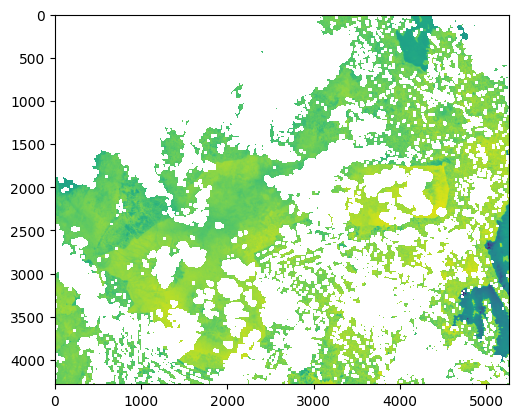

In [161]:
import matplotlib.pyplot as plt
import rasterio

ndvi_data = rasterio.open(new_ndvi_path).read(1)
plt.imshow(ndvi_data)
plt.show()